#  Введение в рекуррентные нейронные сети

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Николенко С., Кадурин А., Архангельская Е. Глубокое обучение.
* https://pytorch.org/docs/stable/nn.html#recurrent-layers
* https://karpathy.github.io/2015/05/21/rnn-effectiveness/
* https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html
* https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Задачи для совместного разбора

1\. Рассмотрите пример работы одного шага простейшего рекуррентного слоя.  

$$ h' = tanh(W_{ih}x + W_{hh}h) $$

![RNN](https://kvitajakub.github.io/img/rnn-unrolled.png)

2\. Рассмотрите пример работы рекуррентных слоев из `torch.nn`.

In [ ]:
import torch.nn as nn
import torch as th

In [ ]:
batch_size, input_size = 16, 32

x0 = th.rand(batch_size, input_size)
x0.shape

torch.Size([16, 32])

In [ ]:
hidden_size = 10
output_size = 5 # 5cls-classification
layer = nn.RNNCell(input_size=input_size, hidden_size=hidden_size)
# fc = nn.Linear(hidden_size, output_size)
# h0 = th.zeros(batch_size, hidden_size)
# h1 = layer(x0, h0) # можно создать первоначальный скрытый слой и запустить layer так же как и в следующих слоях
# o1 = fc(h1)
h1 = layer(x0)
h1.shape

torch.Size([16, 10])

In [ ]:
x1 = th.rand(batch_size, input_size)
x1.shape

torch.Size([16, 32])

In [ ]:
h2 = layer(x1, h1)
h2.shape

torch.Size([16, 10])

In [ ]:
layer = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)

In [ ]:
seq_len = 8
x = th.rand(batch_size, seq_len, input_size)
o, h = layer(x)
x.shape, h.shape, o.shape

(torch.Size([16, 8, 32]), torch.Size([1, 16, 10]), torch.Size([16, 8, 10]))

In [ ]:
o[0, -1, :]

tensor([ 0.4412, -0.3982,  0.1776,  0.8279,  0.7194,  0.4633,  0.7553,  0.3619,
         0.9830, -0.6959], grad_fn=<SliceBackward0>)

In [ ]:
h[0, 0, :] # нужные основные веса

tensor([ 0.4412, -0.3982,  0.1776,  0.8279,  0.7194,  0.4633,  0.7553,  0.3619,
         0.9830, -0.6959], grad_fn=<SliceBackward0>)

In [ ]:
layer = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=False)
seq_len = 8
x = th.rand(seq_len, batch_size, input_size)
o, h = layer(x)
x.shape, h.shape, o.shape

(torch.Size([8, 16, 32]), torch.Size([1, 16, 10]), torch.Size([8, 16, 10]))

## Задачи для самостоятельного решения

In [ ]:
import torch

<p class="task" id="1"></p>

1\. Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть в виде класса `RNN`. Предусмотрите возможность работы с двумя вариантами данных: где данные (x) представлены в виде (batch, seq, feature) и где данные представлены в формате (seq, batch, feature). Создайте тензор `inputs1` размера 16 x 8 x 32 (batch, seq, feature) и пропустите через модель `RNN`. Выведите на экран форму двух полученных тензоров. Проверьте, что тензор `output[:, -1, :]` поэлементно равен `h`.

- [ ] Проверено на семинаре

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.rnn_cell = nn.RNNCell(input_size=input_size, hidden_size=hidden_size)


    def forward(self, x, h=None):
        '''
        x.shape = (batch_size, seq_len, feature_size) - тензор входных данных
        h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN
        '''
        batch_size, seq_len, input_size = x.shape
        if h is None:
            h = torch.zeros(batch_size, self.hidden_size, device=x.device)

        outputs = []

        for t in range(seq_len):

            x_t = x[:, t, :] # (batch_size, input_size)
            h = self.rnn_cell(x_t, h)  # (batch_size, hidden_size)
            # print(h.unsqueeze(1).shape)
            outputs.append(h.unsqueeze(1))


        outputs = torch.cat(outputs, dim=1) # (batch_size, seq_len, hidden_size)
        # print(outputs.shape)

        return outputs, h

In [ ]:
batch_size, input_size = 16, 32
seq_len = 8
hidden_size = 10
d = RNN(input_size, hidden_size)
x = torch.rand(batch_size, seq_len, input_size)
o, h = d.forward(x)
o.shape, h.shape

(torch.Size([16, 8, 10]), torch.Size([16, 10]))

<p class="task" id="2"></p>

2\. Создайте тензор `inputs2` размера 8 x 16 x 32 (seq, batch, feature) и пропустите через модель `RNN`. Выведите на экран форму двух полученных тензоров. Проверьте, что тензор `output[:, -1, :]` поэлементно равен `h`.

- [ ] Проверено на семинаре

доработаем batch_first=False чтобы запускать наш такие inputs

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=True):
        super().__init__()
        self.hidden_size = hidden_size

        self.batch_first = batch_first
        self.rnn_cell = nn.RNNCell(input_size=input_size, hidden_size=hidden_size)


    def forward(self, x, h=None):
        '''
        x.shape = (batch_size, seq_len, feature_size) - тензор входных данных
        h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN
        '''
        if not self.batch_first:
            # (seq, batch, feature) -> (batch, seq, feature)
            x = x.transpose(0, 1)
        batch_size, seq_len, input_size = x.shape
        if h is None:
            h = torch.zeros(batch_size, self.hidden_size, device=x.device)

        outputs = []

        for t in range(seq_len):

            x_t = x[:, t, :] # (batch_size, input_size)
            h = self.rnn_cell(x_t, h)  # (batch_size, hidden_size)
            # print(h.unsqueeze(1).shape)
            outputs.append(h.unsqueeze(1))


        outputs = torch.cat(outputs, dim=1) # (batch_size, seq_len, hidden_size)
        # print(outputs.shape)

        return outputs, h

In [ ]:
d = RNN(input_size, hidden_size, batch_first=False)
x = torch.rand(seq_len, batch_size, input_size)
o, h = d.forward(x)
o.shape, h.shape

(torch.Size([16, 8, 10]), torch.Size([16, 10]))

In [ ]:
o[:, -1, :]

tensor([[ 0.1015, -0.3211,  0.1422,  0.2691,  0.2218, -0.0240, -0.3474, -0.4485,
         -0.7257,  0.2007],
        [ 0.3995,  0.1889, -0.1916, -0.4692,  0.0958, -0.5741, -0.0175, -0.4667,
         -0.3600,  0.5553],
        [ 0.3471,  0.2855,  0.6549,  0.4176,  0.3122, -0.6145,  0.1827, -0.6255,
         -0.5331,  0.3551],
        [ 0.3206, -0.3724,  0.1916,  0.2728, -0.6310, -0.5807,  0.3773, -0.3843,
         -0.6722,  0.0556],
        [-0.6217,  0.1334,  0.5198,  0.2132, -0.3928, -0.6549,  0.5677, -0.3871,
         -0.5953,  0.5571],
        [ 0.3450, -0.4596,  0.1204, -0.0916, -0.5167, -0.3876,  0.3013, -0.7701,
         -0.5103,  0.6217],
        [-0.0983, -0.5860,  0.1330,  0.6002, -0.4277, -0.3598,  0.2747, -0.4803,
         -0.3438,  0.0360],
        [ 0.1595,  0.1540,  0.5689,  0.1406,  0.1315, -0.5541,  0.1580, -0.1165,
         -0.5377,  0.2367],
        [-0.4428, -0.2021,  0.3296,  0.5637,  0.0884, -0.3429,  0.7612, -0.3155,
         -0.2610,  0.2161],
        [ 0.5372,  

In [ ]:
h

tensor([[ 0.1015, -0.3211,  0.1422,  0.2691,  0.2218, -0.0240, -0.3474, -0.4485,
         -0.7257,  0.2007],
        [ 0.3995,  0.1889, -0.1916, -0.4692,  0.0958, -0.5741, -0.0175, -0.4667,
         -0.3600,  0.5553],
        [ 0.3471,  0.2855,  0.6549,  0.4176,  0.3122, -0.6145,  0.1827, -0.6255,
         -0.5331,  0.3551],
        [ 0.3206, -0.3724,  0.1916,  0.2728, -0.6310, -0.5807,  0.3773, -0.3843,
         -0.6722,  0.0556],
        [-0.6217,  0.1334,  0.5198,  0.2132, -0.3928, -0.6549,  0.5677, -0.3871,
         -0.5953,  0.5571],
        [ 0.3450, -0.4596,  0.1204, -0.0916, -0.5167, -0.3876,  0.3013, -0.7701,
         -0.5103,  0.6217],
        [-0.0983, -0.5860,  0.1330,  0.6002, -0.4277, -0.3598,  0.2747, -0.4803,
         -0.3438,  0.0360],
        [ 0.1595,  0.1540,  0.5689,  0.1406,  0.1315, -0.5541,  0.1580, -0.1165,
         -0.5377,  0.2367],
        [-0.4428, -0.2021,  0.3296,  0.5637,  0.0884, -0.3429,  0.7612, -0.3155,
         -0.2610,  0.2161],
        [ 0.5372,  

<p class="task" id="3"></p>

3\. Считайте файл `pets.csv`, приведите имена питомцев к нижнем регистру. Решите проблему с противоречивостью данных (некоторые имена встречаются в обоих классах). Разбейте набор данных на обучающую и тестовую выборку.  Создайте Tokenizer на основе обучающей выборки (токен - __буква__). Добавьте в словарь специальный токен `<PAD>`. Выведите на экран количество токенов в полученном словаре.

- [ ] Проверено на семинаре

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/NLP/8/pets.csv')
df.columns

Index(['имя', 'класс'], dtype='object')

In [ ]:
df.head()

,имя,класс
0,Арчи,собака
1,Алекс,собака
2,Амур,собака
3,Алтaй,собака
4,Альф,собака


In [ ]:
df['класс'].unique()

array(['собака', 'кошка'], dtype=object)

In [ ]:
df['имя'] = df['имя'].str.lower()

In [ ]:
df_unique = df.drop_duplicates(subset='имя', keep='last')

In [ ]:
train_df, test_df = train_test_split(df_unique, test_size=0.2, random_state=42)

In [ ]:
all_letters = "".join(train_df['имя'].tolist())

In [ ]:
vocab = set(all_letters)
print(vocab)

{'м', 'б', '-', 'ы', 'р', 'э', 'ф', 'p', 'ъ', 'г', 'й', 'л', 'в', 'а', 'у', 'к', 'т', 'е', 'п', 'щ', 'д', 'ж', 'ь', 'н', 'ч', 'ё', 'я', ' ', 'х', 'ш', 'a', 'с', 'ю', 'о', 'e', 'з', 'ц', 'и'}


In [ ]:
# vocab.add('<PAD>')

In [ ]:
tokenizer = {token: idx for idx, token in enumerate(['<PAD>'] +sorted(vocab))}
len(tokenizer)

39

In [ ]:
tokenizer

{'<PAD>': 0,
 ' ': 1,
 '-': 2,
 'a': 3,
 'e': 4,
 'p': 5,
 'а': 6,
 'б': 7,
 'в': 8,
 'г': 9,
 'д': 10,
 'е': 11,
 'ж': 12,
 'з': 13,
 'и': 14,
 'й': 15,
 'к': 16,
 'л': 17,
 'м': 18,
 'н': 19,
 'о': 20,
 'п': 21,
 'р': 22,
 'с': 23,
 'т': 24,
 'у': 25,
 'ф': 26,
 'х': 27,
 'ц': 28,
 'ч': 29,
 'ш': 30,
 'щ': 31,
 'ъ': 32,
 'ы': 33,
 'ь': 34,
 'э': 35,
 'ю': 36,
 'я': 37,
 'ё': 38}

<p class="task" id="4"></p>

4\. Создайте класс `PetsDataset`. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами). Закодируйте целыми числами классы питомцев. Создайте два объекта класса `PetsDataset` (для обучающей и тестовой выборки). Выведите на экран их длины.

- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import Dataset


class PetsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

        uniq = df['класс'].unique()
        self.label = {cls: idx for idx, cls in enumerate(uniq)}

        self.pad_token = '<PAD>'
        self.pad_index = tokenizer[self.pad_token]


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        name = row['имя']
        cls = row['класс']

        tokens = [self.tokenizer[i] for i in name]

        tokens = tokens + [self.pad_index] * (self.max_len - len(tokens))

        return torch.tensor(tokens, dtype=torch.long), torch.tensor(self.label[cls], dtype=torch.long)

In [ ]:
max_len = df['имя'].str.len().max()
max_len

22

In [ ]:
train_dataset = PetsDataset(train_df, tokenizer, max_len)
test_dataset = PetsDataset(test_df, tokenizer, max_len)

In [ ]:
train_dataset[10]

(tensor([30,  6, 19, 10, 20, 22,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]),
 tensor(0))

In [ ]:
train_dataset.label, test_dataset.label

({'кошка': 0, 'собака': 1}, {'кошка': 0, 'собака': 1})

In [ ]:
label = {'кошка': 0, 'собака': 1}

<p class="task" id="5"></p>

5\. Используя созданный класс `RNN`, решите задачу классификации категорий питомцев по их именам. Выведите на экран отчет по классификации на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_classes=2, pad_idx=0):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        self.rnn = RNN(input_size=embed_dim, hidden_size=hidden_size)

        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, num_classes)


    def forward(self, x):
        embedded = self.embedding(x)
        outputs, h = self.rnn(embedded)
        logits = self.fc3(F.relu(self.fc2(F.relu(self.fc1(h)))))
        return logits

In [ ]:
vocab_size = len(tokenizer)
embed_dim = 64
hidden_size = 10

In [ ]:
model = RNNClassifier(vocab_size, embed_dim, hidden_size)
model = model.to(device)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm

In [ ]:
train_losses, train_f1s, test_f1s = [], [], []
train_accuracies, test_accuracies = [], []
epochs = 30


for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for x_batch, y_batch in loop:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu())

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    f1_train = f1_score(all_labels, all_preds, average='macro')
    acc_train = accuracy_score(all_labels, all_preds)

    train_losses.append(avg_loss)
    train_f1s.append(f1_train)
    train_accuracies.append(acc_train)

    # Тест
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1).cpu()
            test_preds.extend(preds)
            test_labels.extend(y_batch.cpu())

    f1_test = f1_score(test_labels, test_preds, average='macro')
    acc_test = accuracy_score(test_labels, test_preds)

    test_f1s.append(f1_test)
    test_accuracies.append(acc_test)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} "
          f"| F1 Train: {f1_train:.4f} | F1 Test: {f1_test:.4f} "
          f"| Acc Train: {acc_train:.4f} | Acc Test: {acc_test:.4f}")


Epoch 1/30 | Loss: 0.7097 | F1 Train: 0.4666 | F1 Test: 0.3911 | Acc Train: 0.4666 | Acc Test: 0.6422


Epoch 2/30 | Loss: 0.6557 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 3/30 | Loss: 0.6569 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 4/30 | Loss: 0.6564 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 5/30 | Loss: 0.6561 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 6/30 | Loss: 0.6560 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 7/30 | Loss: 0.6569 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 8/30 | Loss: 0.6557 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 9/30 | Loss: 0.6559 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 10/30 | Loss: 0.6565 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 11/30 | Loss: 0.6556 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 12/30 | Loss: 0.6559 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 13/30 | Loss: 0.6560 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 14/30 | Loss: 0.6558 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 15/30 | Loss: 0.6563 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 16/30 | Loss: 0.6562 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 17/30 | Loss: 0.6554 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 18/30 | Loss: 0.6556 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 19/30 | Loss: 0.5123 | F1 Train: 0.7454 | F1 Test: 0.8214 | Acc Train: 0.7859 | Acc Test: 0.8408


Epoch 20/30 | Loss: 0.4750 | F1 Train: 0.7953 | F1 Test: 0.8197 | Acc Train: 0.8191 | Acc Test: 0.8390


Epoch 21/30 | Loss: 0.4714 | F1 Train: 0.7993 | F1 Test: 0.8219 | Acc Train: 0.8222 | Acc Test: 0.8408


Epoch 22/30 | Loss: 0.4657 | F1 Train: 0.8036 | F1 Test: 0.8201 | Acc Train: 0.8253 | Acc Test: 0.8390


Epoch 23/30 | Loss: 0.4618 | F1 Train: 0.8047 | F1 Test: 0.8201 | Acc Train: 0.8262 | Acc Test: 0.8390


Epoch 24/30 | Loss: 0.4623 | F1 Train: 0.8047 | F1 Test: 0.8201 | Acc Train: 0.8262 | Acc Test: 0.8390


Epoch 25/30 | Loss: 0.4627 | F1 Train: 0.8047 | F1 Test: 0.8201 | Acc Train: 0.8262 | Acc Test: 0.8390


Epoch 26/30 | Loss: 0.4628 | F1 Train: 0.8047 | F1 Test: 0.8201 | Acc Train: 0.8262 | Acc Test: 0.8390


Epoch 27/30 | Loss: 0.4632 | F1 Train: 0.8047 | F1 Test: 0.8201 | Acc Train: 0.8262 | Acc Test: 0.8390


Epoch 28/30 | Loss: 0.4629 | F1 Train: 0.8047 | F1 Test: 0.8201 | Acc Train: 0.8262 | Acc Test: 0.8390


Epoch 29/30 | Loss: 0.4635 | F1 Train: 0.8047 | F1 Test: 0.8201 | Acc Train: 0.8262 | Acc Test: 0.8390


Epoch 30/30 | Loss: 0.4630 | F1 Train: 0.8047 | F1 Test: 0.8201 | Acc Train: 0.8262 | Acc Test: 0.8390


In [ ]:
from collections import Counter
Counter(df['класс'])

Counter({'собака': 1445, 'кошка': 1783})

<p class="task" id="6"></p>

6\. Решите предыщую задачу, заменив собственный модуль `RNN` на модули `nn.RNN`, `nn.LSTM` и `nn.GRU`. Сравните результаты работы.

- [ ] Проверено на семинаре

In [ ]:
import torch.nn as nn

In [ ]:
class MyClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, rnn_type, num_classes=2, pad_idx=0):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        self.rnn_type = rnn_type
        if rnn_type == "RNN":
            self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_size, batch_first=True)
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size=embed_dim, hidden_size=hidden_size, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_size=embed_dim, hidden_size=hidden_size, batch_first=True)


        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, num_classes)


    def forward(self, x):
        embedded = self.embedding(x)
        if self.rnn_type == "LSTM":
            outputs, (h, c) = self.rnn(embedded)
        else:
            outputs, h = self.rnn(embedded)
        h_ = h[-1]
        logits = self.fc3(F.relu(self.fc2(F.relu(self.fc1(h_)))))
        return logits

In [ ]:
def train_and_evaluate(rnn_variant, epochs=10):
    print(f"\n=== model: {rnn_variant} ===")

    vocab_size = len(tokenizer)
    embed_dim = 64
    hidden_size = 10

    model = MyClassifier(vocab_size, embed_dim, hidden_size, rnn_type=rnn_variant)
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    train_losses, train_f1s, test_f1s = [], [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for x_batch, y_batch in loop:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu())
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        f1_train = f1_score(all_labels, all_preds, average='macro')
        acc_train = accuracy_score(all_labels, all_preds)

        train_losses.append(avg_loss)
        train_f1s.append(f1_train)
        train_accuracies.append(acc_train)

        # Оценка на тестовом наборе
        model.eval()
        test_preds, test_labels = [], []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                logits = model(x_batch)
                preds = torch.argmax(logits, dim=1).cpu()
                test_preds.extend(preds)
                test_labels.extend(y_batch.cpu())

        f1_test = f1_score(test_labels, test_preds, average='macro')
        acc_test = accuracy_score(test_labels, test_preds)
        test_f1s.append(f1_test)
        test_accuracies.append(acc_test)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} "
              f"| F1 Train: {f1_train:.4f} | F1 Test: {f1_test:.4f} "
              f"| Acc Train: {acc_train:.4f} | Acc Test: {acc_test:.4f}")

    return {
        "train_losses": train_losses,
        "train_f1s": train_f1s,
        "test_f1s": test_f1s,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
    }


In [ ]:
results = {}
for rnn_variant in ["RNN", "LSTM", "GRU"]:
    results[rnn_variant] = train_and_evaluate(rnn_variant, 30)


=== model: RNN ===


Epoch 1/30 | Loss: 0.6631 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 2/30 | Loss: 0.6557 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 3/30 | Loss: 0.6556 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 4/30 | Loss: 0.6553 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 5/30 | Loss: 0.6545 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 6/30 | Loss: 0.5919 | F1 Train: 0.5707 | F1 Test: 0.7967 | Acc Train: 0.6906 | Acc Test: 0.8122


Epoch 7/30 | Loss: 0.4639 | F1 Train: 0.7968 | F1 Test: 0.8237 | Acc Train: 0.8191 | Acc Test: 0.8408


Epoch 8/30 | Loss: 0.4502 | F1 Train: 0.8052 | F1 Test: 0.8436 | Acc Train: 0.8267 | Acc Test: 0.8569


Epoch 9/30 | Loss: 0.4416 | F1 Train: 0.8035 | F1 Test: 0.8413 | Acc Train: 0.8262 | Acc Test: 0.8569


Epoch 10/30 | Loss: 0.4376 | F1 Train: 0.8079 | F1 Test: 0.8348 | Acc Train: 0.8307 | Acc Test: 0.8515


Epoch 11/30 | Loss: 0.4284 | F1 Train: 0.8161 | F1 Test: 0.8183 | Acc Train: 0.8374 | Acc Test: 0.8301


Epoch 12/30 | Loss: 0.4317 | F1 Train: 0.8120 | F1 Test: 0.8304 | Acc Train: 0.8339 | Acc Test: 0.8479


Epoch 13/30 | Loss: 0.4219 | F1 Train: 0.8151 | F1 Test: 0.8299 | Acc Train: 0.8365 | Acc Test: 0.8462


Epoch 14/30 | Loss: 0.4179 | F1 Train: 0.8159 | F1 Test: 0.8128 | Acc Train: 0.8379 | Acc Test: 0.8247


Epoch 15/30 | Loss: 0.4189 | F1 Train: 0.8166 | F1 Test: 0.8348 | Acc Train: 0.8374 | Acc Test: 0.8515


Epoch 16/30 | Loss: 0.4148 | F1 Train: 0.8194 | F1 Test: 0.8286 | Acc Train: 0.8401 | Acc Test: 0.8462


Epoch 17/30 | Loss: 0.4143 | F1 Train: 0.8185 | F1 Test: 0.8055 | Acc Train: 0.8397 | Acc Test: 0.8175


Epoch 18/30 | Loss: 0.4090 | F1 Train: 0.8190 | F1 Test: 0.8254 | Acc Train: 0.8397 | Acc Test: 0.8408


Epoch 19/30 | Loss: 0.4103 | F1 Train: 0.8191 | F1 Test: 0.8122 | Acc Train: 0.8401 | Acc Test: 0.8265


Epoch 20/30 | Loss: 0.4088 | F1 Train: 0.8156 | F1 Test: 0.8250 | Acc Train: 0.8370 | Acc Test: 0.8426


Epoch 21/30 | Loss: 0.4041 | F1 Train: 0.8257 | F1 Test: 0.8277 | Acc Train: 0.8455 | Acc Test: 0.8444


Epoch 22/30 | Loss: 0.4072 | F1 Train: 0.8194 | F1 Test: 0.8279 | Acc Train: 0.8401 | Acc Test: 0.8426


Epoch 23/30 | Loss: 0.4041 | F1 Train: 0.8224 | F1 Test: 0.8250 | Acc Train: 0.8437 | Acc Test: 0.8426


Epoch 24/30 | Loss: 0.3991 | F1 Train: 0.8222 | F1 Test: 0.8272 | Acc Train: 0.8419 | Acc Test: 0.8462


Epoch 25/30 | Loss: 0.4034 | F1 Train: 0.8180 | F1 Test: 0.8290 | Acc Train: 0.8392 | Acc Test: 0.8462


Epoch 26/30 | Loss: 0.4018 | F1 Train: 0.8240 | F1 Test: 0.8144 | Acc Train: 0.8437 | Acc Test: 0.8283


Epoch 27/30 | Loss: 0.4020 | F1 Train: 0.8145 | F1 Test: 0.8289 | Acc Train: 0.8339 | Acc Test: 0.8444


Epoch 28/30 | Loss: 0.3968 | F1 Train: 0.8282 | F1 Test: 0.8151 | Acc Train: 0.8477 | Acc Test: 0.8283


Epoch 29/30 | Loss: 0.3959 | F1 Train: 0.8229 | F1 Test: 0.8197 | Acc Train: 0.8428 | Acc Test: 0.8354


Epoch 30/30 | Loss: 0.3950 | F1 Train: 0.8226 | F1 Test: 0.8237 | Acc Train: 0.8419 | Acc Test: 0.8426

=== model: LSTM ===


Epoch 1/30 | Loss: 0.6628 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 2/30 | Loss: 0.6552 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 3/30 | Loss: 0.6547 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 4/30 | Loss: 0.5893 | F1 Train: 0.4192 | F1 Test: 0.7762 | Acc Train: 0.6449 | Acc Test: 0.7925


Epoch 5/30 | Loss: 0.4745 | F1 Train: 0.8004 | F1 Test: 0.8093 | Acc Train: 0.8146 | Acc Test: 0.8247


Epoch 6/30 | Loss: 0.4579 | F1 Train: 0.8041 | F1 Test: 0.7912 | Acc Train: 0.8182 | Acc Test: 0.8014


Epoch 7/30 | Loss: 0.4436 | F1 Train: 0.8101 | F1 Test: 0.8076 | Acc Train: 0.8240 | Acc Test: 0.8193


Epoch 8/30 | Loss: 0.4334 | F1 Train: 0.8167 | F1 Test: 0.7949 | Acc Train: 0.8298 | Acc Test: 0.8050


Epoch 9/30 | Loss: 0.4308 | F1 Train: 0.8189 | F1 Test: 0.7953 | Acc Train: 0.8321 | Acc Test: 0.8050


Epoch 10/30 | Loss: 0.4230 | F1 Train: 0.8225 | F1 Test: 0.8131 | Acc Train: 0.8356 | Acc Test: 0.8247


Epoch 11/30 | Loss: 0.4207 | F1 Train: 0.8231 | F1 Test: 0.8228 | Acc Train: 0.8365 | Acc Test: 0.8354


Epoch 12/30 | Loss: 0.4140 | F1 Train: 0.8261 | F1 Test: 0.8273 | Acc Train: 0.8397 | Acc Test: 0.8408


Epoch 13/30 | Loss: 0.4122 | F1 Train: 0.8209 | F1 Test: 0.8238 | Acc Train: 0.8356 | Acc Test: 0.8372


Epoch 14/30 | Loss: 0.4046 | F1 Train: 0.8296 | F1 Test: 0.8279 | Acc Train: 0.8437 | Acc Test: 0.8426


Epoch 15/30 | Loss: 0.4022 | F1 Train: 0.8288 | F1 Test: 0.8197 | Acc Train: 0.8442 | Acc Test: 0.8318


Epoch 16/30 | Loss: 0.3968 | F1 Train: 0.8332 | F1 Test: 0.8215 | Acc Train: 0.8477 | Acc Test: 0.8336


Epoch 17/30 | Loss: 0.3910 | F1 Train: 0.8360 | F1 Test: 0.8301 | Acc Train: 0.8504 | Acc Test: 0.8444


Epoch 18/30 | Loss: 0.3853 | F1 Train: 0.8405 | F1 Test: 0.8158 | Acc Train: 0.8545 | Acc Test: 0.8336


Epoch 19/30 | Loss: 0.3907 | F1 Train: 0.8373 | F1 Test: 0.8279 | Acc Train: 0.8518 | Acc Test: 0.8426


Epoch 20/30 | Loss: 0.3818 | F1 Train: 0.8398 | F1 Test: 0.8104 | Acc Train: 0.8536 | Acc Test: 0.8301


Epoch 21/30 | Loss: 0.3858 | F1 Train: 0.8369 | F1 Test: 0.8100 | Acc Train: 0.8518 | Acc Test: 0.8211


Epoch 22/30 | Loss: 0.3765 | F1 Train: 0.8422 | F1 Test: 0.8283 | Acc Train: 0.8558 | Acc Test: 0.8426


Epoch 23/30 | Loss: 0.3707 | F1 Train: 0.8426 | F1 Test: 0.8266 | Acc Train: 0.8571 | Acc Test: 0.8408


Epoch 24/30 | Loss: 0.3692 | F1 Train: 0.8464 | F1 Test: 0.8180 | Acc Train: 0.8603 | Acc Test: 0.8301


Epoch 25/30 | Loss: 0.3693 | F1 Train: 0.8452 | F1 Test: 0.8197 | Acc Train: 0.8589 | Acc Test: 0.8354


Epoch 26/30 | Loss: 0.3626 | F1 Train: 0.8493 | F1 Test: 0.8330 | Acc Train: 0.8634 | Acc Test: 0.8462


Epoch 27/30 | Loss: 0.3627 | F1 Train: 0.8505 | F1 Test: 0.8224 | Acc Train: 0.8639 | Acc Test: 0.8408


Epoch 28/30 | Loss: 0.3608 | F1 Train: 0.8443 | F1 Test: 0.8001 | Acc Train: 0.8585 | Acc Test: 0.8104


Epoch 29/30 | Loss: 0.3564 | F1 Train: 0.8554 | F1 Test: 0.8386 | Acc Train: 0.8688 | Acc Test: 0.8533


Epoch 30/30 | Loss: 0.3510 | F1 Train: 0.8565 | F1 Test: 0.8253 | Acc Train: 0.8701 | Acc Test: 0.8372

=== model: GRU ===


Epoch 1/30 | Loss: 0.6672 | F1 Train: 0.4066 | F1 Test: 0.3911 | Acc Train: 0.6261 | Acc Test: 0.6422


Epoch 2/30 | Loss: 0.6475 | F1 Train: 0.3891 | F1 Test: 0.3911 | Acc Train: 0.6368 | Acc Test: 0.6422


Epoch 3/30 | Loss: 0.5521 | F1 Train: 0.5185 | F1 Test: 0.8056 | Acc Train: 0.6762 | Acc Test: 0.8283


Epoch 4/30 | Loss: 0.4715 | F1 Train: 0.7919 | F1 Test: 0.8184 | Acc Train: 0.8146 | Acc Test: 0.8354


Epoch 5/30 | Loss: 0.4306 | F1 Train: 0.8112 | F1 Test: 0.8206 | Acc Train: 0.8276 | Acc Test: 0.8372


Epoch 6/30 | Loss: 0.4260 | F1 Train: 0.8087 | F1 Test: 0.8023 | Acc Train: 0.8258 | Acc Test: 0.8157


Epoch 7/30 | Loss: 0.4159 | F1 Train: 0.8151 | F1 Test: 0.7992 | Acc Train: 0.8325 | Acc Test: 0.8122


Epoch 8/30 | Loss: 0.4127 | F1 Train: 0.8156 | F1 Test: 0.8149 | Acc Train: 0.8316 | Acc Test: 0.8301


Epoch 9/30 | Loss: 0.4061 | F1 Train: 0.8222 | F1 Test: 0.8106 | Acc Train: 0.8379 | Acc Test: 0.8265


Epoch 10/30 | Loss: 0.4031 | F1 Train: 0.8202 | F1 Test: 0.8131 | Acc Train: 0.8370 | Acc Test: 0.8283


Epoch 11/30 | Loss: 0.3990 | F1 Train: 0.8271 | F1 Test: 0.8114 | Acc Train: 0.8419 | Acc Test: 0.8265


Epoch 12/30 | Loss: 0.3920 | F1 Train: 0.8331 | F1 Test: 0.7804 | Acc Train: 0.8482 | Acc Test: 0.7925


Epoch 13/30 | Loss: 0.3870 | F1 Train: 0.8344 | F1 Test: 0.8202 | Acc Train: 0.8504 | Acc Test: 0.8372


Epoch 14/30 | Loss: 0.3780 | F1 Train: 0.8361 | F1 Test: 0.8106 | Acc Train: 0.8527 | Acc Test: 0.8265


Epoch 15/30 | Loss: 0.3875 | F1 Train: 0.8238 | F1 Test: 0.7988 | Acc Train: 0.8406 | Acc Test: 0.8122


Epoch 16/30 | Loss: 0.3736 | F1 Train: 0.8387 | F1 Test: 0.8140 | Acc Train: 0.8545 | Acc Test: 0.8283


Epoch 17/30 | Loss: 0.3694 | F1 Train: 0.8444 | F1 Test: 0.8062 | Acc Train: 0.8594 | Acc Test: 0.8211


Epoch 18/30 | Loss: 0.3693 | F1 Train: 0.8432 | F1 Test: 0.8123 | Acc Train: 0.8585 | Acc Test: 0.8283


Epoch 19/30 | Loss: 0.3643 | F1 Train: 0.8463 | F1 Test: 0.8175 | Acc Train: 0.8612 | Acc Test: 0.8354


Epoch 20/30 | Loss: 0.3646 | F1 Train: 0.8463 | F1 Test: 0.8175 | Acc Train: 0.8616 | Acc Test: 0.8354


Epoch 21/30 | Loss: 0.3627 | F1 Train: 0.8485 | F1 Test: 0.7929 | Acc Train: 0.8639 | Acc Test: 0.8068


Epoch 22/30 | Loss: 0.3598 | F1 Train: 0.8493 | F1 Test: 0.8019 | Acc Train: 0.8643 | Acc Test: 0.8175


Epoch 23/30 | Loss: 0.3541 | F1 Train: 0.8519 | F1 Test: 0.7971 | Acc Train: 0.8661 | Acc Test: 0.8104


Epoch 24/30 | Loss: 0.3521 | F1 Train: 0.8541 | F1 Test: 0.7950 | Acc Train: 0.8688 | Acc Test: 0.8086


Epoch 25/30 | Loss: 0.3548 | F1 Train: 0.8552 | F1 Test: 0.7950 | Acc Train: 0.8692 | Acc Test: 0.8104


Epoch 26/30 | Loss: 0.3514 | F1 Train: 0.8545 | F1 Test: 0.8071 | Acc Train: 0.8692 | Acc Test: 0.8229


Epoch 27/30 | Loss: 0.3467 | F1 Train: 0.8591 | F1 Test: 0.7864 | Acc Train: 0.8728 | Acc Test: 0.7996


Epoch 28/30 | Loss: 0.3503 | F1 Train: 0.8552 | F1 Test: 0.8006 | Acc Train: 0.8692 | Acc Test: 0.8157


Epoch 29/30 | Loss: 0.3459 | F1 Train: 0.8567 | F1 Test: 0.7963 | Acc Train: 0.8706 | Acc Test: 0.8104


Epoch 30/30 | Loss: 0.3418 | F1 Train: 0.8590 | F1 Test: 0.7890 | Acc Train: 0.8728 | Acc Test: 0.8032


In [ ]:
print("\n=== Итоговое сравнение по Test Accuracy и Test F1 ===")
for rnn_variant in results:
    final_acc = results[rnn_variant]["test_accuracies"][-1]
    final_f1 = results[rnn_variant]["test_f1s"][-1]
    print(f"{rnn_variant}: Test Accuracy = {final_acc:.4f}, Test F1 = {final_f1:.4f}")


=== Итоговое сравнение по Test Accuracy и Test F1 ===
RNN: Test Accuracy = 0.8426, Test F1 = 0.8237
LSTM: Test Accuracy = 0.8372, Test F1 = 0.8253
GRU: Test Accuracy = 0.8032, Test F1 = 0.7890


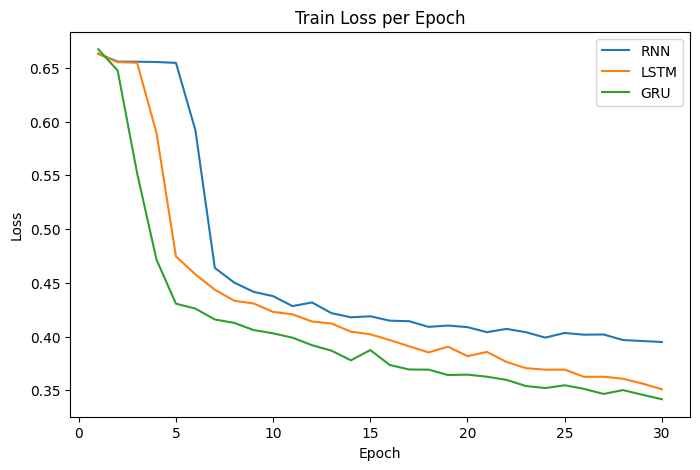

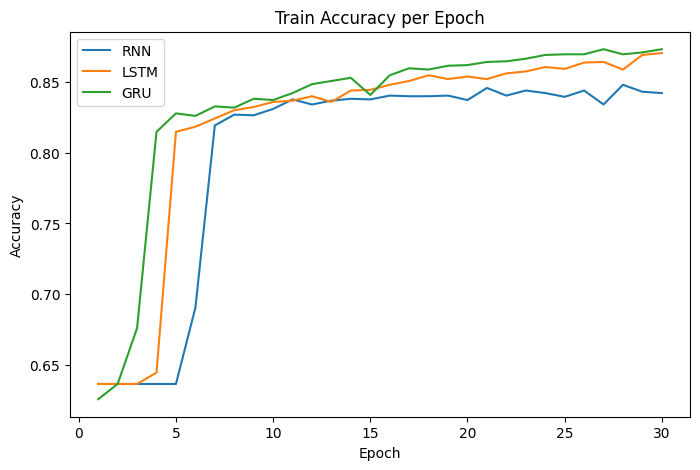

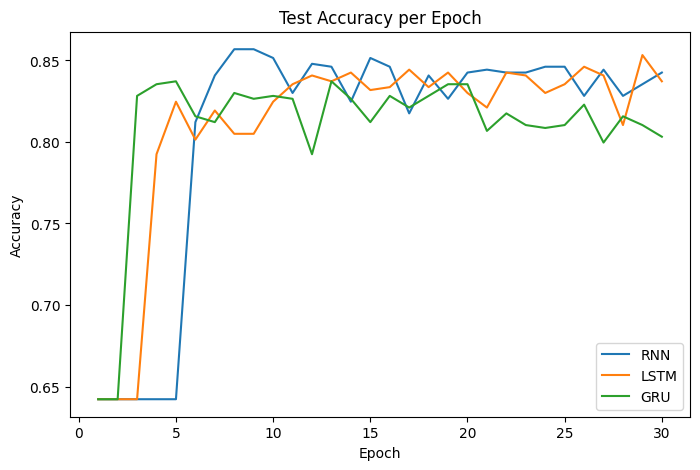

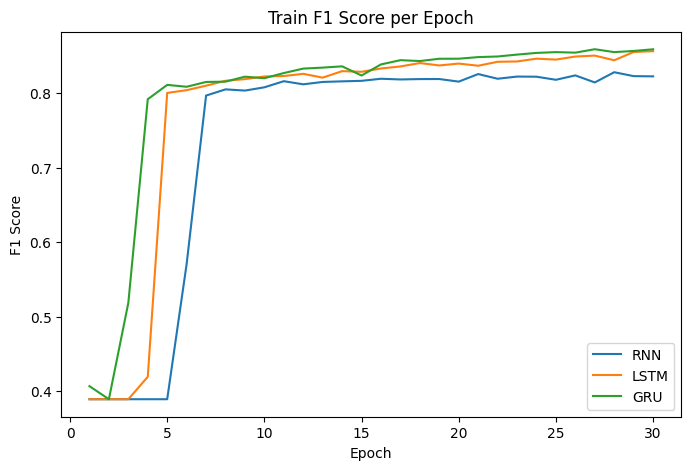

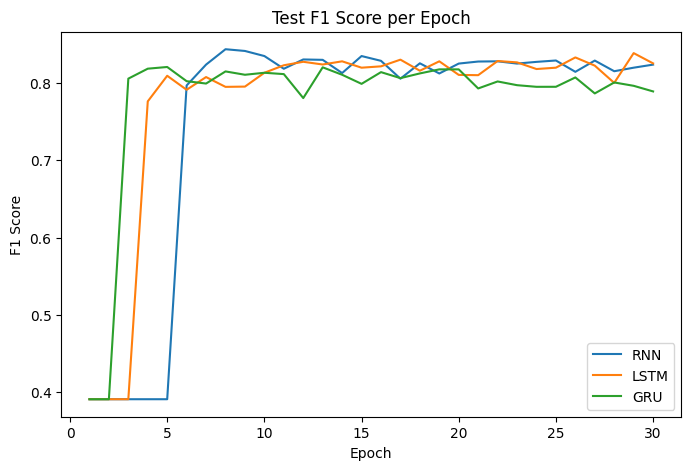

In [ ]:
import matplotlib.pyplot as plt

# Количество эпох, использованных при обучении
epochs = range(1, len(next(iter(results.values()))["train_losses"]) + 1)

# График для тренировочного loss
plt.figure(figsize=(8, 5))
for rnn_variant, metrics in results.items():
    plt.plot(epochs, metrics["train_losses"], label=rnn_variant)
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# График для тренировочной точности
plt.figure(figsize=(8, 5))
for rnn_variant, metrics in results.items():
    plt.plot(epochs, metrics["train_accuracies"], label=rnn_variant)
plt.title("Train Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# График для тестовой точности
plt.figure(figsize=(8, 5))
for rnn_variant, metrics in results.items():
    plt.plot(epochs, metrics["test_accuracies"], label=rnn_variant)
plt.title("Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# График для тренировочного F1 score
plt.figure(figsize=(8, 5))
for rnn_variant, metrics in results.items():
    plt.plot(epochs, metrics["train_f1s"], label=rnn_variant)
plt.title("Train F1 Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# График для тестового F1 score
plt.figure(figsize=(8, 5))
for rnn_variant, metrics in results.items():
    plt.plot(epochs, metrics["test_f1s"], label=rnn_variant)
plt.title("Test F1 Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.show()


Было много попыток адекватно обучить RNN

получилось сделать поменяв оптимайзер на AdamW чтобы устранить от проблем затухания весов со временем
Так же добавить больше эпох

Как результат видим что RNN тоже дает плоды чуть позже

Однако он все же устарел и дает чуть более слабые метрики

GRU возможно переобучается тк выдает на трейне метрики лучше всех, но на тесте просаживается в сравнении с другими моделями, что в итоге делает модель **LSTM** более стабильной и новой